In [438]:
#import pyfits #modulo para leer archivos fits
from astropy.io import fits
import matplotlib.pyplot as plt #modulo para graficar
import numpy as np #este modulo es para trabajar con matrices como en matlab
import scipy as sp

def values(h,j):
    N=h['NAXIS'+str(j)];
    val=np.zeros(N);
    for i in range(0,N):
        val[i] = (i+1-float(h['CRPIX'+str(j)]))*float(h['CDELT'+str(j)]) + float(h['CRVAL'+str(j)]);
    return val;

cubo	= fits.open("cubo_de_datos.fits") #abrir objeto cubo de datos
data 	= cubo[0].data #extraer matriz de datos
header	= cubo[0].header #extraer el header del archivo fits


#Estos seran los tres arreglos con los valores reales de los tres ejes del cubo
velocidad=values(header,1)
longitud=values(header,2)
latitud=values(header,3)

In [439]:
# Se crea una funcion que para un indice de longitud(l) fija, se recorre latitud(b) y se calcula el rms de las
# velocidades
# Esta misma funcion recorre el cubo de las velocidades asociadas a l y b, hasta que se llega a una
# velocidad que es 5 veces mayor que el rms, esta ultima se guarda un arreglo

def fmin(l, vs):
    #recorre latitud
    for q in range(33):
        T1=data[q][l][:]
        rms=np.sqrt(np.mean(T1**2))   #calcula rms
        #recorre velocidad
        for w in range(306):
            if data[q][l][w]>=5*rms:  #buscamos que no sea ruido
                vs[q]=velocidad[w]    #guardamos la primera v donde T mayor a 5rms
                break

vmin=np.zeros(385)
bvmin=np.zeros(385)
R=np.zeros(385)
R_=np.zeros(385)
R0=8.5 #kPc
vsol=220 #km/s

#maximorum
# Se recorren las longitudes y se busca la velocidad más negativa (mayor en modulo), se guarda esta
# y su latitud asociada
# Se obtiene un arreglo de R con la ecuacion R =| R0 · cos(l π/180 ) |

for i in range(385):
    vs=np.zeros(33)
    fmin(i, vs)
    v1=vs[0]
    b1=latitud[0]
    for j in range(32):
        if vs[j+1]<v1:
            v1=vs[j+1]
            b1=latitud[j+1]
    vmin[i]=v1
    bvmin[i]=b1
    R[i]=np.abs(R0*np.sin(longitud[i]*sp.pi/180.)) #R0*sin(l)
    R_[i]=np.abs(R0*np.cos(longitud[i]*sp.pi/180.))

    
# Se obtiene la Vtan con Vtan = −Vmin − Vsol · sin(lπ/180 ), donde Vmin es la velocidad mayor en
# modulo para l, y Vsol es la velocidad de rotacion del sol.    
#velocidad de rotacion
#velocidad angular

vR=np.zeros(385)
wR=np.zeros(385)
for i in range(385):
    vR[i]= vmin[i]*(np.abs(np.sin(longitud[i]*np.pi/180.))/np.sin(longitud[i]*np.pi/180.)) + np.abs(vsol*np.sin(longitud[i]*np.pi/180.))
    wR[i]= vmin[i]/(R0*np.sin(longitud[i]*np.pi/180.)*3.086e+16) + vsol/(R0*3.086e+16)

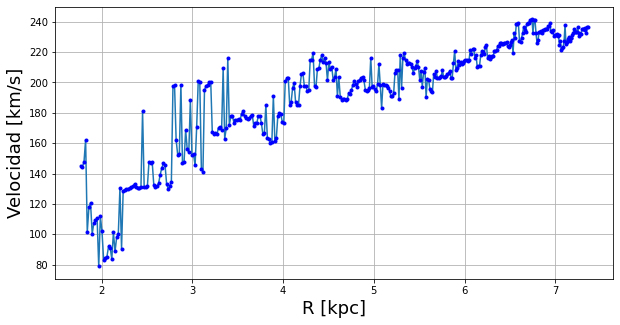

In [458]:
#ahora grafican el espectro
plt.figure(figsize=(10,5))
plt.plot(R, vR)
plt.plot(R, vR, 'b.')
plt.xlabel('R [kpc]',fontsize=18)
plt.ylabel('Velocidad [km/s]',fontsize=18)
plt.grid()
#cuidado pues para llamar en data el orden es indice lat, indice longitud, indice velocidad, al reves del orden del header
#plt.xlim(-100, 0)
plt.show()


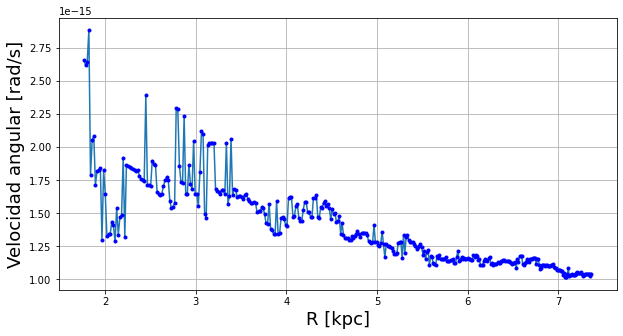

In [456]:
#ahora grafican el espectro
plt.figure(figsize=(10,5))
plt.plot(R, wR)
plt.plot(R, wR, 'b.')
plt.xlabel('R [kpc]',fontsize=18)
plt.ylabel('Velocidad angular [rad/s]',fontsize=18)
plt.grid()

#cuidado pues para llamar en data el orden es indice lat, indice longitud, indice velocidad, al reves del orden del header
#plt.xlim(-100, 0)
plt.show()

In [442]:
Z=np.zeros(385)
for i in range(385):
    Z[i] = R0*np.cos(longitud[i]*np.pi/180.)*bvmin[i]*np.pi/180.

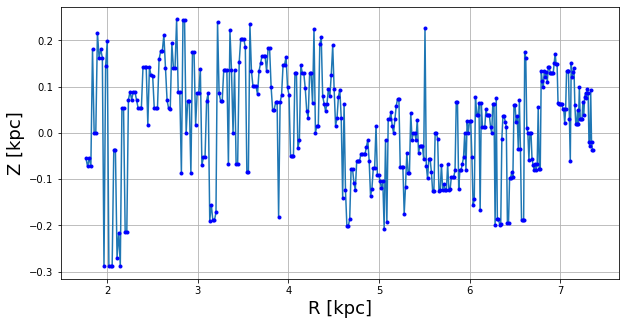

In [460]:
#ahora grafican el espectro
plt.figure(figsize=(10,5))
plt.plot(R, Z)
plt.plot(R, Z, 'b.')
plt.xlabel('R [kpc]',fontsize=18)
plt.ylabel('Z [kpc]',fontsize=18)
plt.grid()

#cuidado pues para llamar en data el orden es indice lat, indice longitud, indice velocidad, al reves del orden del header
#plt.xlim(-100, 0)
plt.show()

In [444]:
from scipy.optimize import curve_fit

#definimos la constante G en unidades adecuadas
G=4.302e-6 # Units: pc x M_sun^(-1) x (km/s)^2 

def masapuntual(R,M0):
    M=M0
    v=np.sqrt(G*M/R)
    return v

def discouniforme(R,S):
    M=np.pi*R**2*S
    v=np.sqrt(G*M/R)
    return v

def esferauniforme(R,rho):
    M=(4/3)*np.pi*R**3*rho
    v=np.sqrt(G*M/R)
    return v

def masa_mas_esfera(R,M0,rho):
    M=M0 + (4/3)*np.pi*R**3*rho
    v=np.sqrt(G*M/R)
    return v

def masa_mas_disco(R,M0,S):
    M=M0 + np.pi*R**2*S
    v=np.sqrt(G*M/R)
    return v

mpuntual,covmpuntual=curve_fit(masapuntual, R, vR,bounds=(0, [np.inf]))
duniforme,covduniforme=curve_fit(discouniforme, R, vR,bounds=(0, [np.inf]))
euniforme,coveuniforme=curve_fit(esferauniforme, R, vR,bounds=(0, [np.inf]))
mpuntualesfera,covmpuntualesfera=curve_fit(masa_mas_esfera, R, vR,bounds=(0, [np.inf, np.inf]))
mpuntualdisco,covmpuntualdisco=curve_fit(masa_mas_disco, R, vR,bounds=(0, [np.inf, np.inf]))

print("M0: " +  "{:.3e}".format(mpuntual[0]) + " masas solares")

M0: 3.228e+10 masas solares


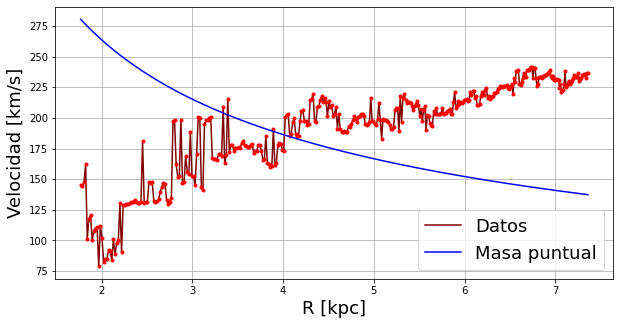

In [462]:
#Graficamos el ajuste
plt.figure(figsize=(10,5))
plt.plot(R, vR, 'maroon',label='Datos')
plt.plot(R, vR, 'r.')
plt.plot(R, masapuntual(R,mpuntual[0]),'b',label='Masa puntual')
plt.xlabel('R [kpc]', fontsize=18)
plt.ylabel('Velocidad [km/s]', fontsize=18)
plt.grid()
plt.legend(fontsize=18)
plt.show()

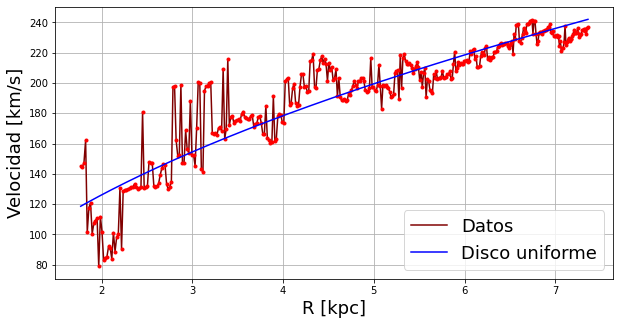

In [463]:
#Graficamos el ajuste
plt.figure(figsize=(10,5))
plt.plot(R, vR, 'maroon',label='Datos')
plt.plot(R, vR, 'r.')
plt.plot(R, discouniforme(R,duniforme[0]),'b',label='Disco uniforme')
plt.xlabel('R [kpc]',fontsize=18)
plt.ylabel('Velocidad [km/s]',fontsize=18)
plt.grid()
plt.legend(fontsize=18)
plt.show()

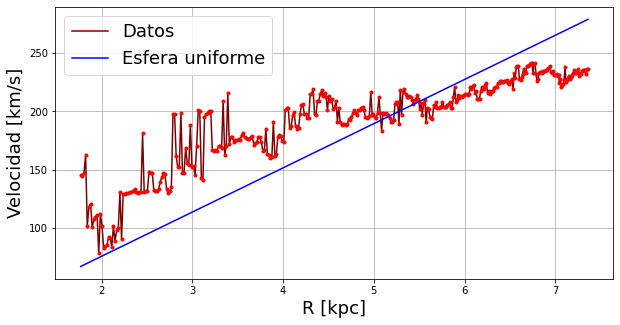

In [464]:
#Graficamos el ajuste
plt.figure(figsize=(10,5))
plt.plot(R, vR, 'maroon',label='Datos')
plt.plot(R, vR, 'r.')
plt.plot(R, esferauniforme(R,euniforme[0]),'b',label='Esfera uniforme')
plt.xlabel('R [kpc]',fontsize=18)
plt.ylabel('Velocidad [km/s]',fontsize=18)
plt.grid()
plt.legend(fontsize=18)
plt.show()

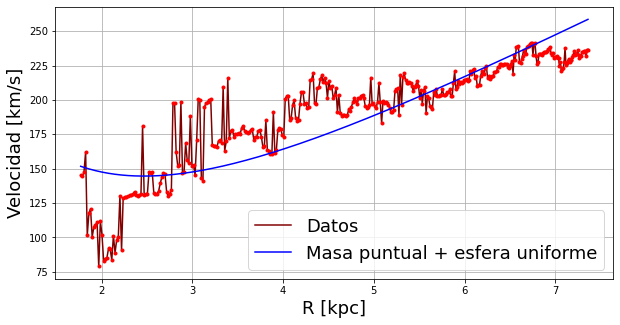

In [465]:
#Graficamos el ajuste
plt.figure(figsize=(10,5))
plt.plot(R, vR, 'maroon',label='Datos')
plt.plot(R, vR, 'r.')
plt.plot(R, masa_mas_esfera(R,mpuntualesfera[0],mpuntualesfera[1]),'b',label='Masa puntual + esfera uniforme')
plt.xlabel('R [kpc]',fontsize=18)
plt.ylabel('Velocidad [km/s]',fontsize=18)
plt.grid()
plt.legend(fontsize=18)
plt.show()

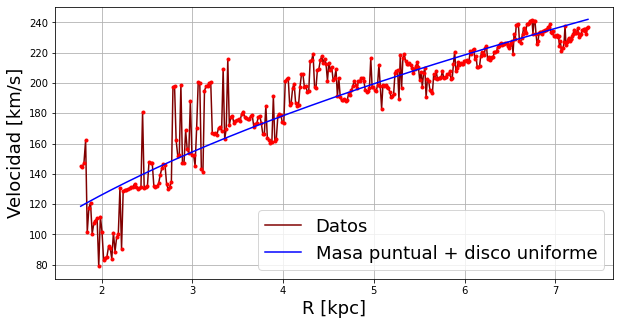

In [466]:
#Graficamos el ajuste
plt.figure(figsize=(10,5))
plt.plot(R, vR, 'maroon',label='Datos')
plt.plot(R, vR, 'r.')
plt.plot(R, masa_mas_disco(R,mpuntualdisco[0],mpuntualdisco[1]),'b',label='Masa puntual + disco uniforme')
plt.xlabel('R [kpc]',fontsize=18)
plt.ylabel('Velocidad [km/s]',fontsize=18)
plt.grid()
plt.legend(fontsize=18)
plt.show()

In [450]:
mpuntualdisco

array([2.21282581e-04, 5.88778172e+08])

In [451]:
duniforme

array([5.88778173e+08])

In [452]:
mpuntualesfera

array([7.98058835e+09, 6.37221178e+07])

In [453]:
euniforme

array([79644445.08673736])

In [454]:
mpuntual

array([3.22845989e+10])